nodes.shape=(6, 6, 2)


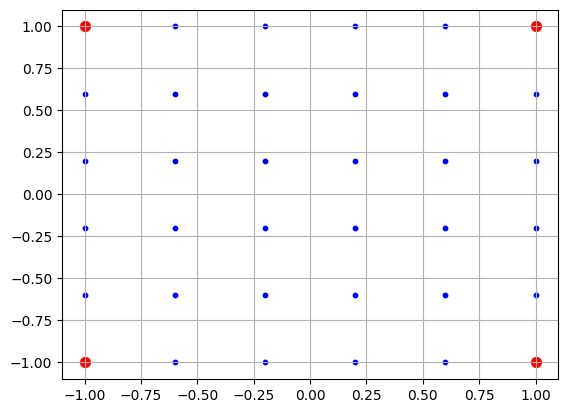

In [1]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = 4
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 6
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
# nodes = nodes.reshape((1,) + nodes.shape)
# nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

# Specify depots
## One depot node
# depot_indices = np.array([[0, 0]])
## Four depot nodes (one in each corner)
depot_indices = np.array([[0, 0], [n-1,n-1], [0, n-1], [n-1, 0]])
# print(f"{depot_indices=}")
target_indices = []
for i in range(n):
    for j in range(n):
        is_depot = False
        for depot in depot_indices:
            if i == depot[0] and j == depot[1]:
                is_depot = True
                continue
        if not is_depot:
            target_indices.append([i,j])
target_indices = np.array(target_indices)
# print(f"{target_indices=}")

# Chose starting depot node
# Make all robots start from same depot
# B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(nodes[:,:,0], nodes[:,:,1], c='blue', s=10)
plt.scatter(nodes[depot_indices[:,0],depot_indices[:,1],0], nodes[depot_indices[:,0],depot_indices[:,1], 1], c='red', s=50)
plt.grid()
plt.show()

In [2]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = np.sqrt((nodes[i1,j1,0]-nodes[i2,j2,0]) ** 2 + (nodes[i1,j1,1]-nodes[i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
print(f"{cost.shape=}")


cost.shape=(6, 6, 6, 6)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
x = m.addMVar((k,n,n,n,n), name='x', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    are_both_depot = False
    for d1 in depot_indices:
        if d1[0] != i1 or d1[1] != j1 : continue
        for d2 in depot_indices:
            if d2[0] != i2 or d2[1] != j2: continue
            are_both_depot = True
    if not are_both_depot:
        for ki in range(k):
            _ = m.addConstr(x[ki,i1,j1,i2,j2] <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2419685
Academic license 2419685 - for non-commercial use only - registered to lu___@icloud.com


In [4]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i1,j1,:,:].sum() == 1 for i1, j1 in target_indices)
_ = m.addConstrs(x[:,:,:,i1,j1].sum() == 1 for i1, j1 in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at same position B_k
    _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() <= 1)
    _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() <= 1)
    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,:,i1,j1]-x[ki,i1,j1,:,:]).sum() == 0 for i1 in range(n) for j1 in range(n))

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, j, i, j] == 0 for i in range(n) for j in range(n))

In [5]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,n,n,n,n), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i1, j1 in target_indices:
        for i2, j2 in itertools.product(range(n), range(n)):
            right_side += x[ki,i1,j1,i2,j2]
    _ = m.addConstr((p[ki,B_k[ki,0],B_k[ki,1],:,:] - p[ki,:,:,B_k[ki,0],B_k[ki,1]]).sum() == right_side)
    _ = m.addConstrs((p[ki,:,:,i1,j1] - p[ki,i1,j1,:,:]).sum() == x[ki,i1,j1,:,:].sum() for i1, j1 in target_indices)

    # (13) Make sure target capacity doesn't change when passing through a depot
    for i, (i1, j1) in enumerate(depot_indices):
        if i == ki: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for i2, j2 in itertools.product(range(n), range(n)):
            left_side += p[ki,i2,j2,i1,j1] - p[ki,i1,j1,i2,j2]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i1,j1,i2,j2] <= len(target_indices) * x[ki,i1,j1,i2,j2] for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))

In [6]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
L = np.sqrt(8) * 4 # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
r = m.addMVar((n,n), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    _ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in target_indices)

    # (17) and (18)
    _ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)

    # (19)
    _ = m.addConstrs(r[i1,j1] - cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in depot_indices)

In [7]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

In [8]:
def visualize_paths_brute_force(edges):
    subplot_per_axis = int(np.ceil(np.sqrt(k)))
    fig, axs = plt.subplots(subplot_per_axis, subplot_per_axis)
    fig.suptitle(f"Paths for all robots (sum of costs={(cost * edges).sum():.3f})")
    fig.tight_layout()
    
    for ki in range(k):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        ax = axs[int(np.floor(ki/subplot_per_axis))][ki%subplot_per_axis]
        ax.set_title(f"Robot #{ki} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(nodes[:, :, 0], nodes[:, :, 1], c='blue', s=10)
        ax.scatter(nodes[depot_indices[:, 0], depot_indices[:, 1], 0], nodes[depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
        ax.scatter(nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1], c='red', s=100)

        for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
            if edges[ki,i1, j1, i2, j2] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i1, j1, 0], nodes[i1, j1, 1], c="purple", s=8)
                ax.scatter(nodes[i2, j2, 0], nodes[i2, j2, 1], c="purple", s=8)
                ax.plot([nodes[i1, j1, 0], nodes[i2, j2, 0]], [nodes[i1, j1, 1], nodes[i2, j2, 1]], color="purple", linewidth=1)

        ax.grid()
    plt.show()

In [9]:
def get_next_nodes(edges, node):
    next_nodes = []
    for i1, j1 in itertools.product(range(n), range(n)):
        if edges[node[0],node[1],i1, j1]:
            next_nodes.append((i1,j1))
    return next_nodes

def visualize_paths_faster(edges):
    for ki in range(k):
        print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        fig = plt.figure()
        fig.suptitle(f"Path for Robot #{ki}")
        plt.scatter(nodes[:, :, 0], nodes[:, :, 1], c='blue', s=10)
        plt.scatter(nodes[depot_indices[:, 0], depot_indices[:, 1], 0], nodes[depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
        plt.scatter(nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1], c='red', s=100)

        search_ongoing = True
        found = set()
        visited = set()
        # path_lookup = {}
        prev_node = (B_k[ki][0], B_k[ki][1])
        while search_ongoing:
            if (depot_indices == prev_node).all(1).any():
                print(f" -> D{prev_node}/({nodes[prev_node[0], prev_node[1], 0]:.2f},{nodes[prev_node[0], prev_node[1], 1]:.2f})")
            else:
                print(f" -> T{prev_node}/({nodes[prev_node[0], prev_node[1], 0]:.2f},{nodes[prev_node[0], prev_node[1], 1]:.2f})")

            neighbor_nodes = get_next_nodes(edges[ki], prev_node)
            print(f"\t{neighbor_nodes=}")

            for neighbor_node in neighbor_nodes:
                if not (depot_indices == neighbor_node).all(1).any() and neighbor_node not in found:
                    found.add(neighbor_node)

            found_next_node = False
            for neighbor_node in neighbor_nodes:
                if neighbor_node not in visited:
                    plt.scatter(nodes[prev_node[0], prev_node[1], 0], nodes[prev_node[0], prev_node[1], 1], c="purple", s=8)
                    plt.plot([nodes[prev_node[0], prev_node[1], 0], nodes[neighbor_node[0], neighbor_node[1], 0]], [nodes[prev_node[0], prev_node[1], 1], nodes[neighbor_node[0], neighbor_node[1], 1]], color="purple", linewidth=1)

                    if not (depot_indices == neighbor_node).all(1).any():
                        visited.add(neighbor_node)
                    prev_node = neighbor_node
                    found_next_node = True
                    break

            if found_next_node:
                search_ongoing = True
            elif not found_next_node and len(found) != len(visited):
                search_ongoing = True
                # print(f"{(found - visited)=}")
                print("Visualizing another loop...")
                prev_node = (found - visited).pop()
            else:
                search_ongoing = False

            # print(f"{found_next_node=} , {len(found)=} {len(visited)=}")

        plt.grid()
        plt.show()

In [10]:
class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    def __init__(self, model):
        self.model = model
        
    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            visualize_paths_brute_force(MILPSolver.min_cost_edges)

    def solve(self):
        self.model.optimize(MILPSolver.cb)


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2419685 - for non-commercial use only - registered to lu___@icloud.com
Optimize a model with 20540 rows, 10405 columns and 86692 nonzeros
Model fingerprint: 0x981fdaae
Variable types: 37 continuous, 10368 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-01, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 5664 rows and 292 columns
Presolve time: 0.04s
Presolved: 14876 rows, 10113 columns, 80148 nonzeros
Variable types: 33 continuous, 10080 integer (5016 binary)
Found a new solution with lower cost(77.290)!


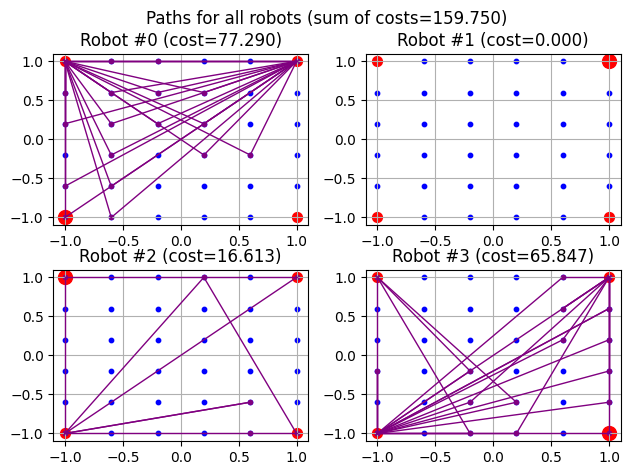

Found heuristic solution: objective 77.2897516

Root relaxation: objective 3.300000e+00, 7761 iterations, 0.71 seconds (2.60 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.30000    0  143   77.28975    3.30000  95.7%     -    1s
Found a new solution with lower cost(6.686)!


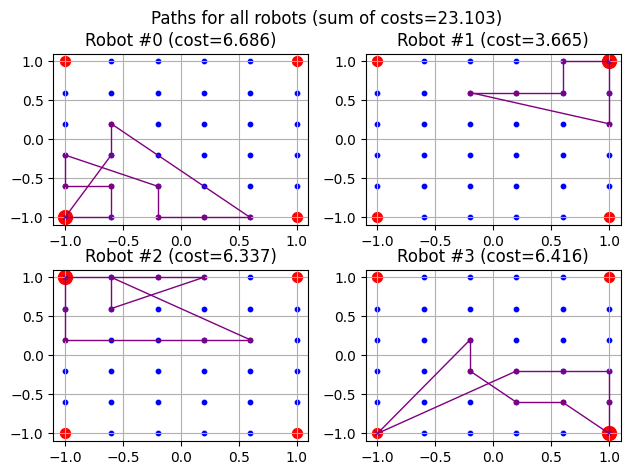

H    0     0                       6.6859107    3.30000  50.6%     -    2s
     0     0    3.30000    0  237    6.68591    3.30000  50.6%     -    2s
Found a new solution with lower cost(4.808)!


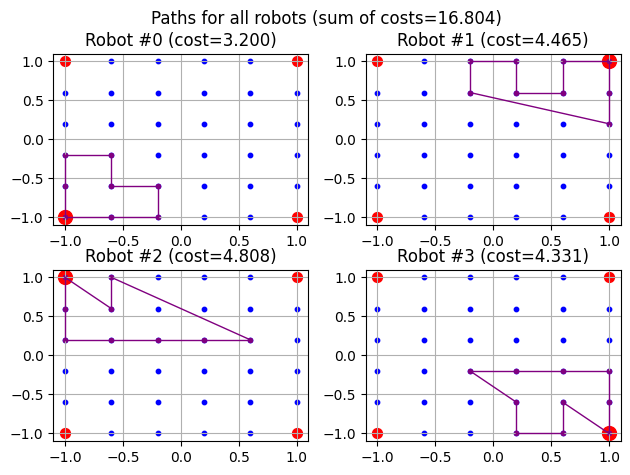

H    0     0                       4.8079059    3.30000  31.4%     -    4s
Found a new solution with lower cost(4.800)!


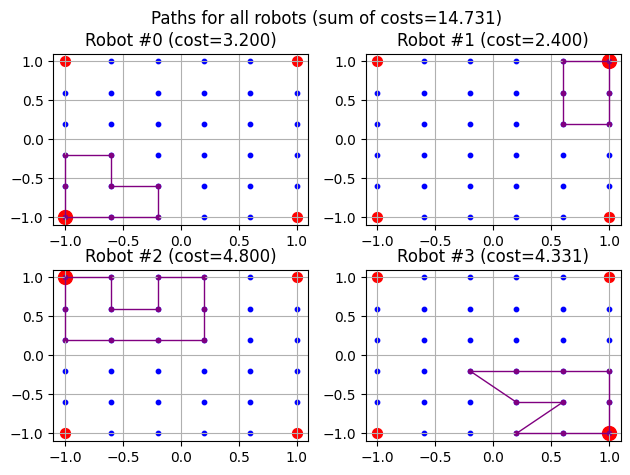

H    0     0                       4.8000000    3.30000  31.2%     -    5s
     0     0    3.30000    0  253    4.80000    3.30000  31.2%     -    5s
     0     0    3.30000    0  175    4.80000    3.30000  31.2%     -    6s
     0     0    3.30000    0  276    4.80000    3.30000  31.2%     -    7s
Found a new solution with lower cost(4.566)!


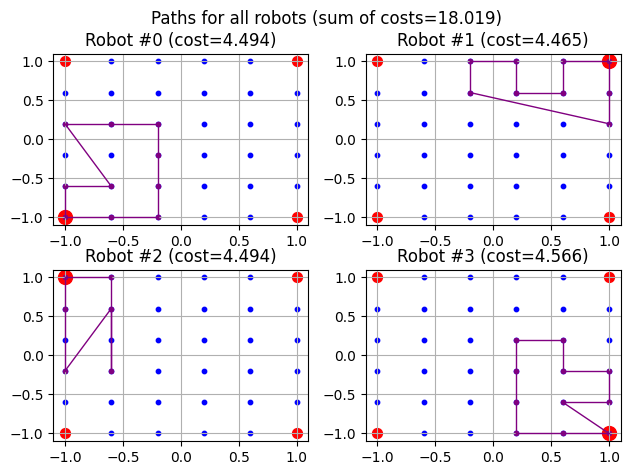

H    0     0                       4.5656854    3.30000  27.7%     -    9s
     0     0    3.30000    0  178    4.56569    3.30000  27.7%     -   10s
Found a new solution with lower cost(4.494)!


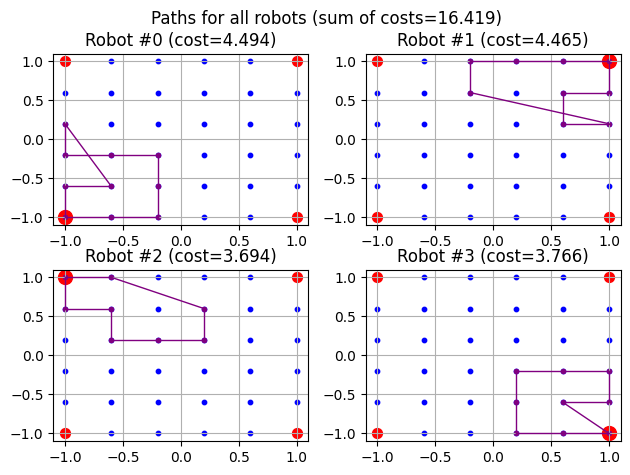

H    0     0                       4.4944272    3.30000  26.6%     -   11s
     0     0    3.30000    0  283    4.49443    3.30000  26.6%     -   11s
Found a new solution with lower cost(4.331)!


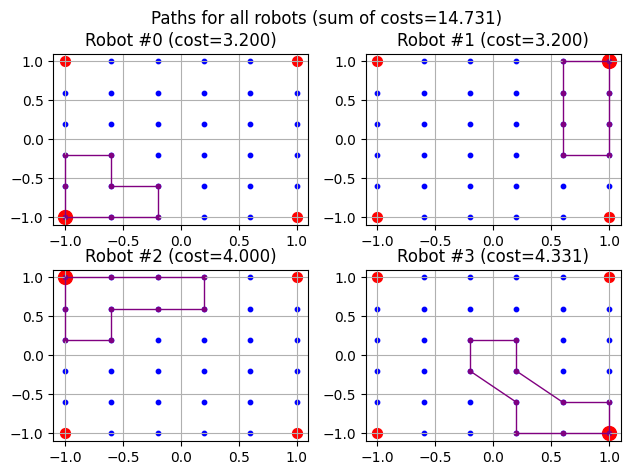

H    0     0                       4.3313708    3.30000  23.8%     -   14s
Found a new solution with lower cost(4.260)!


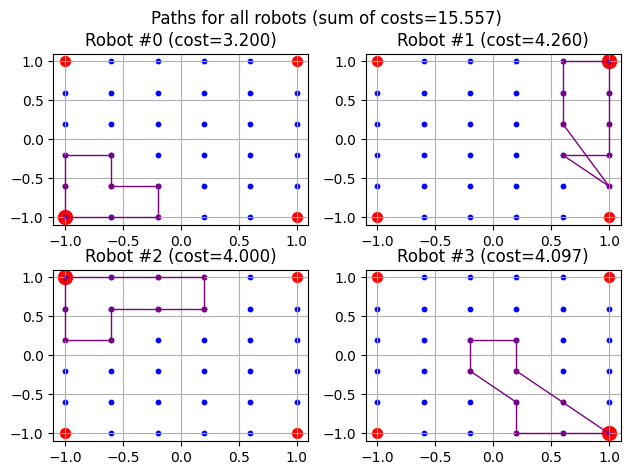

H    0     0                       4.2601126    3.30000  22.5%     -   14s
     0     0    3.30000    0  202    4.26011    3.30000  22.5%     -   15s
     0     0    3.30000    0  321    4.26011    3.30000  22.5%     -   16s
     0     0    3.30000    0  188    4.26011    3.30000  22.5%     -   18s
     0     0    3.30000    0  180    4.26011    3.30000  22.5%     -   19s
Found a new solution with lower cost(4.097)!


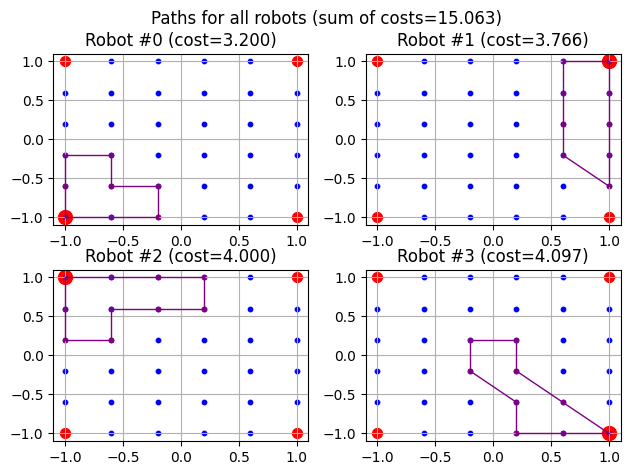

H    0     0                       4.0970563    3.30000  19.5%     -   25s
     0     2    3.30000    0  180    4.09706    3.30000  19.5%     -   26s
    15    30    3.30000    4  325    4.09706    3.30000  19.5%  3406   30s
    29    43    3.30000    5  360    4.09706    3.30000  19.5%  4299   38s
Found a new solution with lower cost(4.000)!


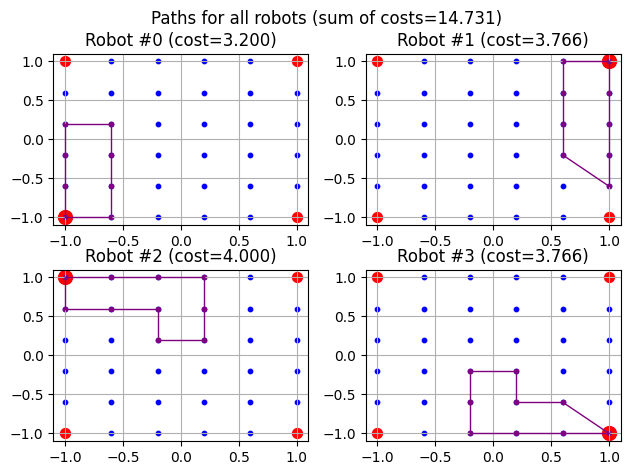

H   30    43                       4.0000000    3.30000  17.5%  4155   38s
Found a new solution with lower cost(3.766)!


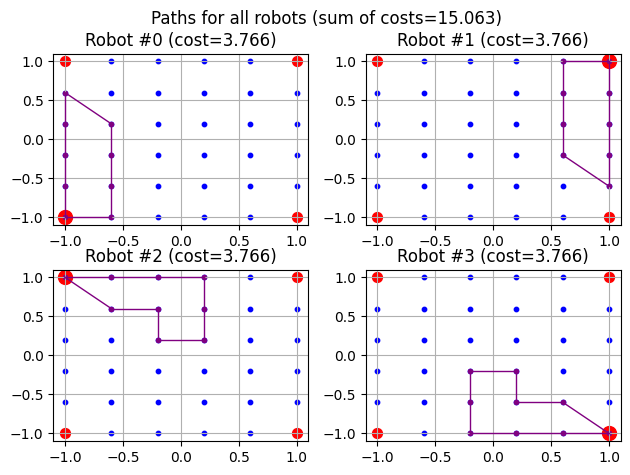

H   71    78                       3.7656854    3.30000  12.4%  3111   42s
   158   142    3.37728   11  291    3.76569    3.30000  12.4%  2165   45s
   225   182    3.37728   14  291    3.76569    3.30000  12.4%  1840   56s
   349   296    3.42286   18  294    3.76569    3.30000  12.4%  1582   60s
   393   333    3.43670   19  278    3.76569    3.30000  12.4%  1493   65s
   724   558    3.46199   29  306    3.76569    3.30000  12.4%  1111   70s
  1113   830    3.55597   44  302    3.76569    3.30000  12.4%   994   75s
  1206   843    3.55973   47  292    3.76569    3.30000  12.4%   979   89s
  1220   913    3.61926   47  286    3.76569    3.30000  12.4%   979   91s
  1481  1034    3.71695   65  281    3.76569    3.30000  12.4%   914   95s
  1815  1233 infeasible   10         3.76569    3.30000  12.4%   892  100s
  1940  1235    3.66748   69  153    3.76569    3.30000  12.4%   891  105s
  1941  1236    3.49949   20  166    3.76569    3.30000  12.4%   891  111s
  1944  1238    3.44779  

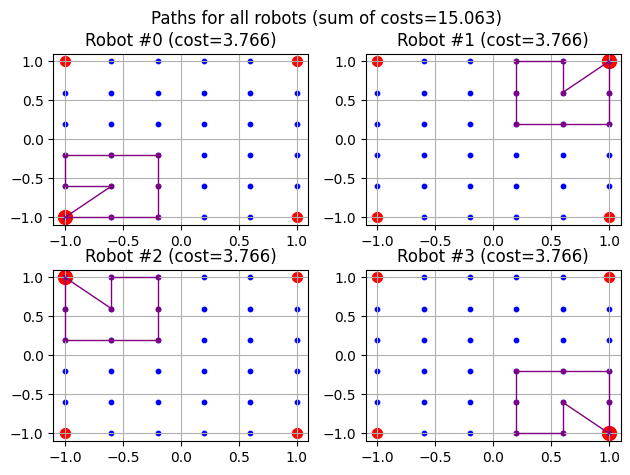

* 2519  1463             102       3.7656854    3.71998  1.21%  1127  276s
Found a new solution with lower cost(3.766)!


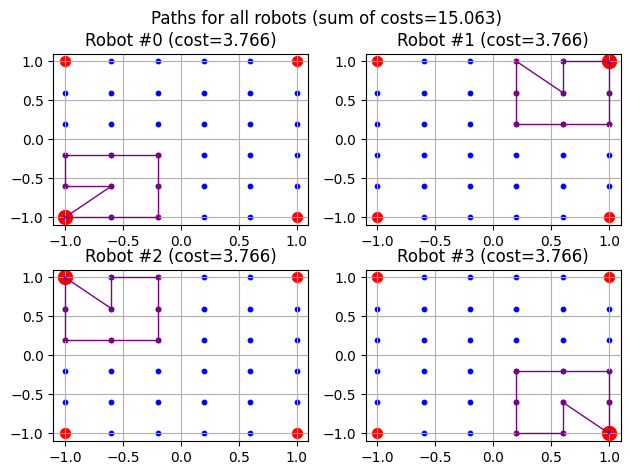

* 2520  1397             101       3.7656854    3.71998  1.21%  1127  276s
Found a new solution with lower cost(3.766)!


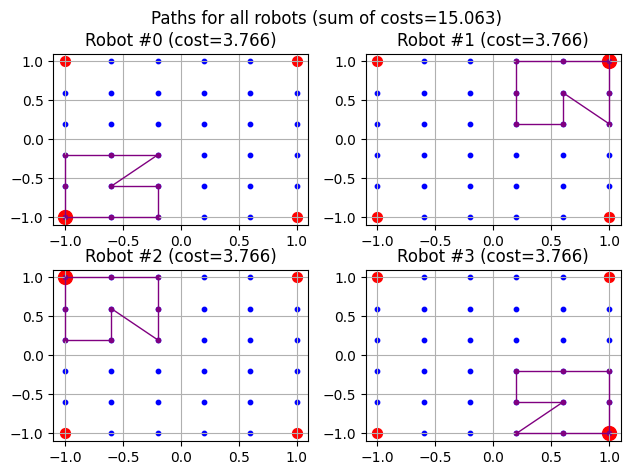

* 3048  1430              98       3.7656854    3.71998  1.21%   965  278s
Found a new solution with lower cost(3.766)!


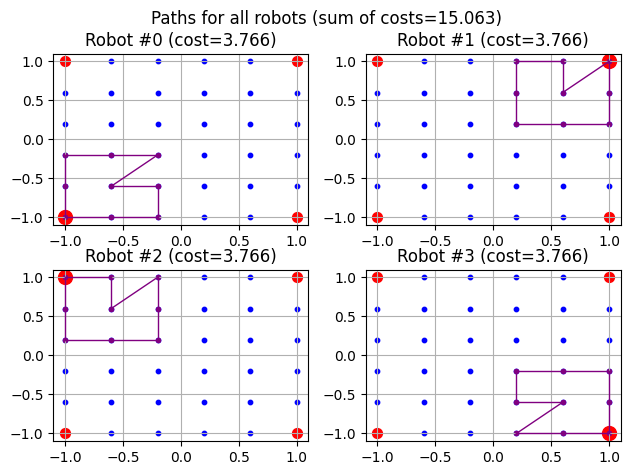

* 3103  1367             100       3.7656854    3.71998  1.21%   950  278s
  3399  1385    3.72009   77  227    3.76569    3.72006  1.21%   887  280s
Found a new solution with lower cost(3.766)!


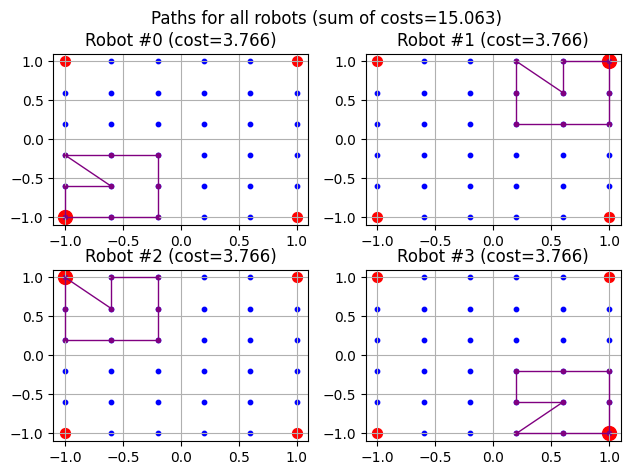

* 3804  1339              87       3.7656854    3.72009  1.21%   813  281s
Found a new solution with lower cost(3.766)!


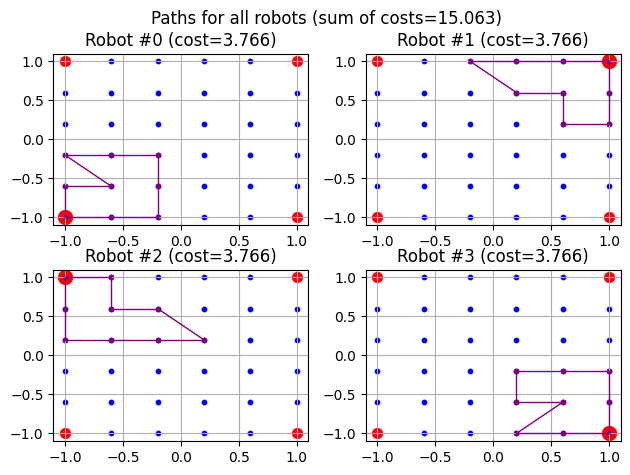

* 4506  1246              97       3.7656854    3.72151  1.17%   740  284s
  4608  1266    3.73651   88  197    3.76569    3.72151  1.17%   732  285s
Found a new solution with lower cost(3.766)!


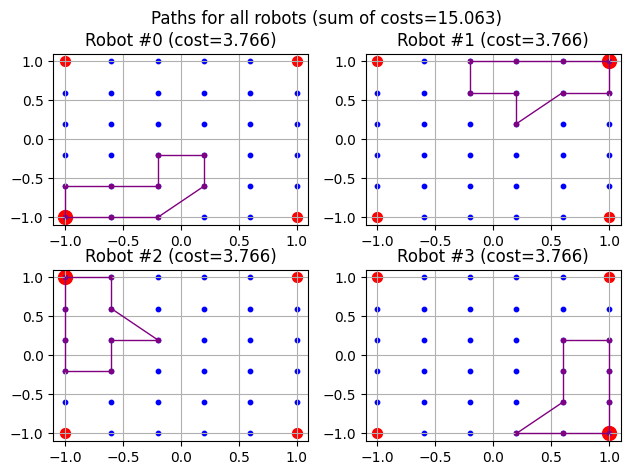

* 4639  1200              87       3.7656854    3.72151  1.17%   729  285s
  6054  1371     cutoff   85         3.76569    3.72378  1.11%   646  290s
  8235  2248    3.74594  118  120    3.76569    3.72765  1.01%   546  295s
 10563  3193    3.74432  124  120    3.76569    3.72979  0.95%   490  300s
 12312  3737    3.75385  110  201    3.76569    3.73037  0.94%   467  305s
 15073  4122    3.74262   85  190    3.76569    3.73385  0.85%   435  310s
 16990  4621     cutoff   86         3.76569    3.73611  0.79%   432  315s
 18257  4809    3.76569   86  116    3.76569    3.73659  0.77%   427  320s
 19467  5580    3.74995  110  188    3.76569    3.73687  0.77%   423  325s
 22931  6484     cutoff  137         3.76569    3.73687  0.77%   404  330s
 25772  6856    3.74621   86  199    3.76569    3.73753  0.75%   395  335s
 28505  7157    3.74629  105  175    3.76569    3.73962  0.69%   391  341s
 29962  7315 infeasible   90         3.76569    3.74083  0.66%   393  345s
Found a new solution with

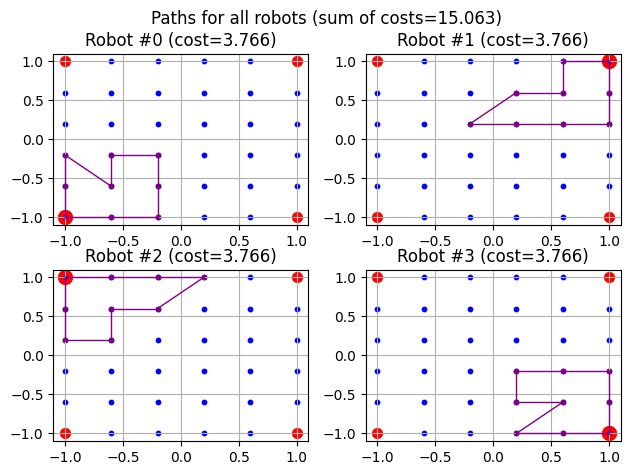

*31965  7574             154       3.7656854    3.74199  0.63%   391  348s
 32154  7927    3.75592  108  152    3.76569    3.74199  0.63%   391  350s
 34144  8199    3.76568  101  184    3.76569    3.74237  0.62%   390  356s
 35525  8343 infeasible   97         3.76569    3.74276  0.61%   393  363s
 36621  8704    3.74565  117  162    3.76569    3.74499  0.55%   392  366s
 38202  9382 infeasible  105         3.76569    3.74528  0.54%   390  372s
 40451  9928    3.74528   95  226    3.76569    3.74528  0.54%   386  392s
 42711 10487    3.76568   96  168    3.76569    3.74528  0.54%   385  396s
 44738 11052 infeasible  147         3.76569    3.74528  0.54%   384  401s
 46924 11572    3.76569   99  103    3.76569    3.74528  0.54%   382  406s
 48942 12244    3.74528   96  174    3.76569    3.74528  0.54%   382  411s
 50978 12836    3.74528  137  196    3.76569    3.74528  0.54%   381  416s
 53152 13330    3.76568  128  164    3.76569    3.74528  0.54%   379  421s
 55152 13762    3.74802  

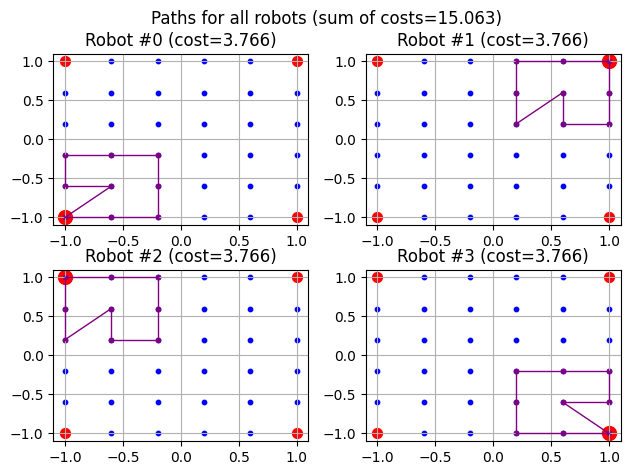

*121426 14244             102       3.7656853    3.75017  0.41%   437  620s
 122636 14070     cutoff  112         3.76569    3.75036  0.41%   437  627s
 124730 13841    3.75444  105  165    3.76569    3.75056  0.40%   439  635s
 126546 13325     cutoff   96         3.76569    3.75075  0.40%   440  642s
 129513 12993 infeasible  107         3.76569    3.75110  0.39%   442  648s
 131382 12735 infeasible  158         3.76569    3.75130  0.38%   443  655s
 133299 12376    3.75738   95  179    3.76569    3.75151  0.38%   445  661s
 135172 11978 infeasible  131         3.76569    3.75163  0.37%   447  668s
 137126 11510 infeasible  111         3.76569    3.75187  0.37%   449  676s
 138685 11078     cutoff  148         3.76569    3.75209  0.36%   450  682s
 140745 10539     cutoff  114         3.76569    3.75238  0.35%   452  689s
 142566  9958 infeasible  107         3.76569    3.75270  0.34%   454  695s
 144598  9336    3.75484   99  242    3.76569    3.75298  0.34%   456  702s
 146751  856

In [11]:
m._x = x
solver = MILPSolver(m)
solver.solve()

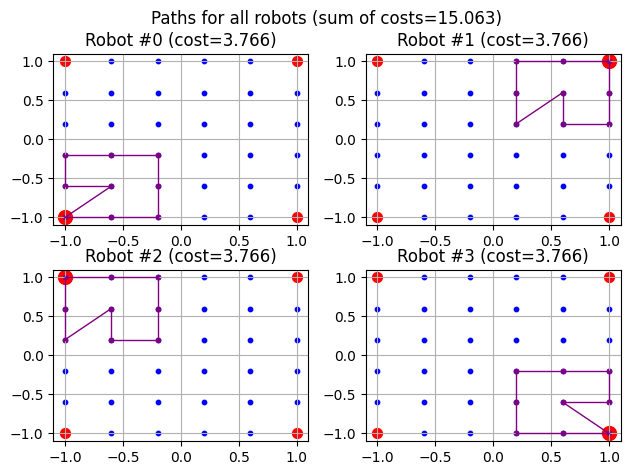

In [12]:
visualize_paths_brute_force(MILPSolver.min_cost_edges)
# visualize_paths_faster(MILPSolver.min_cost_edges)